<a href="https://colab.research.google.com/github/MaximeCurralCPE/Data-Mining/blob/main/ProjetDataMining.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Projet Data Mining

Romain GAUD and Maxime Curral

The main goal of this program is to use an image set from Intel to propose an image to a client based on his taste.

The database used can be found [here](https://www.kaggle.com/datasets/puneet6060/intel-image-classification)

The critera it is based upon are the following:


*   The environment, which is determined by the name of the file containing the photo:
  * 'buildings'
  * 'forest'
  * 'glacier'
  * 'mountain'
  * 'sea'
  * 'street'
*   The year, which will be a random value between 1995 and 2021,
*   The photograph, which will be a random name selected from a list,
*   The main color, determined by a k-mean algortihm.

**NOTE:** Run the entire code for each block to work.





## Used Libraries

In [ ]:
import os
from PIL import Image
import numpy
import math
import pandas as pd
import matplotlib.pyplot as plot
from sklearn.cluster import KMeans
import json
import random
from os.path import exists
#from ipywidgets.widgets.widget_selection import ToggleButtons
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
#import ipywidgets as widgets
#from IPython.display import clear_output
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from sklearn import tree
from PIL import Image
import warnings


## Gaussian distribution

Using a gaussian distribution to randomly select the year of the photo

In [ ]:
def getYear():
    mu = 2007 # mean of 2007
    sigma = 4 # change the year

    min = 1990
    max = 2022

    ret=0
    
    while(not(min<=ret<=max)):
      ret = math.floor(random.gauss(mu, sigma))
    
    return ret 

"""
test = []

for i in range(10000):
  test.append(getYear())

print(min(test))
print(max(test))
"""

'\ntest = []\n\nfor i in range(10000):\n  test.append(getYear())\n\nprint(min(test))\nprint(max(test))\n'

In [ ]:
def getPhotographer():
  photographer = ["Romain","Maxime","Michel","Denis","Jaquie","Fares"]
  return photographer[random.randint(0,len(photographer)-1)]

## Data Collection
**NOTE:** Works on a google colab python notebook.

This part of the code is mostly extracted from [here](https://gist.github.com/jayspeidell/d10b84b8d3da52df723beacc5b15cb27).

## First attempt: extracting the code from kaggle

In [ ]:
"""
!cd /
!pip install kaggle # Installing the kaggle API to automatically update the dB

api_token = {"username":"romaingaud","key":"a5d6baeac0e8b20f305272f58fc188df"} #Create a new token for each usage
# kaggle.com>Account>API>Create New API Token

import json
import zipfile
import os


!mkdir /content/images # Creating the folder were the raw data will be written
!mkdir /root/.kaggle # Creating the folder to write the API token

with open('/root/.kaggle/kaggle.json', 'w') as file: 
    json.dump(api_token, file)

!chmod 600 /root/.kaggle/kaggle.json # Changing the permission on the kaggle file to protect it

!kaggle config path -p /content 
!kaggle datasets download -d puneet6060/intel-image-classification # Downloading

os.chdir('/content/images') # Changing folder to be in the raw data folder

for file in os.listdir(): # Unzipping and adding the photo's to content/data/
    zip_ref = zipfile.ZipFile(file, 'r')
    zip_ref.extractall()
    zip_ref.close()

"""

'\n!cd /\n!pip install kaggle # Installing the kaggle API to automatically update the dB\n\napi_token = {"username":"romaingaud","key":"a5d6baeac0e8b20f305272f58fc188df"} #Create a new token for each usage\n# kaggle.com>Account>API>Create New API Token\n\nimport json\nimport zipfile\nimport os\n\n\n!mkdir /content/images # Creating the folder were the raw data will be written\n!mkdir /root/.kaggle # Creating the folder to write the API token\n\nwith open(\'/root/.kaggle/kaggle.json\', \'w\') as file: \n    json.dump(api_token, file)\n\n!chmod 600 /root/.kaggle/kaggle.json # Changing the permission on the kaggle file to protect it\n\n!kaggle config path -p /content \n!kaggle datasets download -d puneet6060/intel-image-classification # Downloading\n\nos.chdir(\'/content/images\') # Changing folder to be in the raw data folder\n\nfor file in os.listdir(): # Unzipping and adding the photo\'s to content/data/\n    zip_ref = zipfile.ZipFile(file, \'r\')\n    zip_ref.extractall()\n    zip_ref


## Using a git repository
The code below is an alternate way to collect the images. We shall used it as extracting from kaggle requires asking each time for an API token.

In [ ]:
!mkdir /content/images # Creating the folder were the raw data will be written
os.chdir('/content/images') # Changing folder to be in the raw data folder
! git clone https://github.com/MaximeCurralCPE/Data-Mining.git
!mkdir /content/colors # Creating the folder were the raw data will be written
os.chdir('/content/colors') # Changing folder to be in the raw data folder
! git clone https://github.com/cheprasov/json-colors.git
!mkdir /content/images/Data-Mining/archive/seg_tested # Creating the folder were the raw data will be written

mkdir: cannot create directory ‘/content/images’: File exists
fatal: destination path 'Data-Mining' already exists and is not an empty directory.
mkdir: cannot create directory ‘/content/colors’: File exists
fatal: destination path 'json-colors' already exists and is not an empty directory.
mkdir: cannot create directory ‘/content/images/Data-Mining/archive/seg_tested’: File exists


## Testing for EXIF

The code here is used to test for exif. As Kaggle strips it's data of it, it is useless.

In [ ]:
"""
!pip install Pillow
!pip install exif
!cd /content/images

import PIL

img = PIL.Image.open('/content/images/seg_pred/seg_pred/10004.jpg')
print(img._getexif)
exif_data = img._getexif()
print(exif_data)
"""

"\n!pip install Pillow\n!pip install exif\n!cd /content/images\n\nimport PIL\n\nimg = PIL.Image.open('/content/images/seg_pred/seg_pred/10004.jpg')\nprint(img._getexif)\nexif_data = img._getexif()\nprint(exif_data)\n"

## Labeling and Annotation

## Color block

Ths block is tasked with associating an rgb value with a string color from a color json database. It shall then be used to analyse the image later.

In [ ]:
'''
  Converts the rgb data to the closest color available.
  @PARAM : rgb = array containing the colors between 0 and 255
  @RET : a string with the name of the closest color
'''
def findName(rgb):
  
  dataframe=pd.read_json("/content/colors/json-colors/colors.json") # Importing all the color names and putting them into a dataframe

  dataframe['hex'] = dataframe['hex'].str[1:] # Taking out the hashtag out of the hex value

  # The following lines extract the hex values and convert it to an int for each main color (red, blue and green).
  # Then substracting it by the rgb values of the main color in the image
  dataframe['r'] = abs(dataframe['hex'].str[:2].apply(int, base=16) - rgb[0])
  dataframe['g'] = abs(dataframe['hex'].str[2:4].apply(int, base=16) - rgb[1])
  dataframe['b'] = abs(dataframe['hex'].str[4:6].apply(int, base=16) - rgb[2])

  dataframe['sum'] = (dataframe['r'] + dataframe['g'] + dataframe['b'])  # Summing the columns

  df_main_color = dataframe.loc[dataframe['sum'] == dataframe['sum'].min()] # Getting the minimum value of the sum which would be the closest color to the one entered
  
  color_name = df_main_color.head().iloc[0]['name'] # Acessing the str value of the row containing the minimum value (taking the first one if there are multiple ones)
  
  return  color_name

def getMainColor(image_analysis):
  num = 1 # number of clusters given by user

  imgfile = Image.open(image_analysis)

  numarray = numpy.array(imgfile.getdata(), numpy.uint8)
  clusters = KMeans(n_clusters = num) # adapting the algorithm to the number defined by the user
  clusters.fit(numarray)

  color_rgb = [
    math.ceil(clusters.cluster_centers_[0][0]), 
    math.ceil(clusters.cluster_centers_[0][1]),
    math.ceil(clusters.cluster_centers_[0][2])
  ]

  return findName(color_rgb)

## Saving the raw data as analysis

In [ ]:
def saveJSON(data,result):

  for row in data: # Completing the data with random years and photographs
    row.append(getYear())
    row.append(getPhotographer())

  dataframe=pd.DataFrame(data,
                         columns=['environment','main_color','year','photographer'])
  resultframe=pd.DataFrame(result,
                           columns= ['result'])
  
  dataframe.to_json("/content/data.json")
  resultframe.to_json("/content/result.json")

Another methode adding data to the file along the way for piwidget, did not work.

In [ ]:
"""
  for i in range(len(data[0])):
    data[1].append(random.randint(1995,2021))
    data[2].append(photographer[random.randint(0,len(photographer)-1)])

def writeInfo(imgpath, environment, result):
  # VARIABLES
  
  photographer = ["Romain","Maxime","Michel","Denis","Jaquie","Fares"]
  train_path = "/content/images/Data-Mining/archive/seg_train/seg_train"

  # To add color ,getMainColor(imgpath)
  data = [environment,random.randint(1995,2021),photographer[random.randint(0,len(photographer)-1)]]
  result = [result]

  if(not (exists("/content/data.json") and exists("/content/result.json"))):

    dataframe=pd.read_json("/content/data.json", orient='index')
    resultframe=pd.read_json("/content/result.json", orient='index')

    print(dataframe)

    dataframe.append(pd.DataFrame(data, index=
                           ['environment','year','photographer']))
                           
    resultframe.append(pd.DataFrame(result,index=
                           ['result']))
    print(dataframe)
    
  
  else:
    # To add color ,'main_color'
    dataframe=pd.DataFrame(data,index=
                           ['environment','year','photographer'])
    resultframe=pd.DataFrame(result,index=
                           ['result'])

  print(imgpath, environment, result)
  json_data=''
  json_result =''
  dataframe.to_json(json_data)
  print(json_data)
  resultframe.to_json("/content/result.json")
"""

'\n  for i in range(len(data[0])):\n    data[1].append(random.randint(1995,2021))\n    data[2].append(photographer[random.randint(0,len(photographer)-1)])\n\ndef writeInfo(imgpath, environment, result):\n  # VARIABLES\n  \n  photographer = ["Romain","Maxime","Michel","Denis","Jaquie","Fares"]\n  train_path = "/content/images/Data-Mining/archive/seg_train/seg_train"\n\n  # To add color ,getMainColor(imgpath)\n  data = [environment,random.randint(1995,2021),photographer[random.randint(0,len(photographer)-1)]]\n  result = [result]\n\n  if(not (exists("/content/data.json") and exists("/content/result.json"))):\n\n    dataframe=pd.read_json("/content/data.json", orient=\'index\')\n    resultframe=pd.read_json("/content/result.json", orient=\'index\')\n\n    print(dataframe)\n\n    dataframe.append(pd.DataFrame(data, index=\n                           [\'environment\',\'year\',\'photographer\']))\n                           \n    resultframe.append(pd.DataFrame(result,index=\n               

## Data Analyses

We want the user to like or dislike a few images among those in the *seg_train* folder. Once they have liked/disliked 10 images, the algorithm below should be able to extract informations about the user's preferences such as their favorite environment or predominant color.

## Person generated likes

In [ ]:
def randomPicture():
  global environment

  #randomly select the environment from which we take the image
  environment = random.choice(os.listdir("/content/images/Data-Mining/archive/seg_train"))

  filename_image = random.choice(os.listdir("/content/images/Data-Mining/archive/seg_train" +"/"+ str(environment)))

  #randomly select an image from the selected environment and display it to the user
  imgpath = "/content/images/Data-Mining/archive/seg_train"+ "/" + str(environment) + "/" + filename_image

  image = mpimg.imread(imgpath)
  imgplot = plt.imshow(image)

  return imgpath


#ask the user if he likes the image
def chooseLike():
  data = []
  result = []
  flag = True

  while flag:
    path = randomPicture()

    print("Choose if you like the picture or not: L or D")
    print("Type E to exit")
    
    choice = input("")

    if choice in ['L','D','E']:
      if choice == 'L':
        result.append(['Like'])
        data.append([environment,getMainColor(path)])
      elif choice == 'D':
        result.append(['Dislike'])
        data.append([environment,getMainColor(path)])
      else:
        flag = False
        saveJSON(data,result)
    else:
      print("Wrong choice")


Tried using piwidget, did not work out well

In [ ]:
"""
def generateButton():
    buttons_list = [ widgets.Button(description="Like"), 
            widgets.Button(description="Dislike"),
            widgets.Button(description="Exit")]
    output = widgets.Output()

    for i,button in enumerate(buttons_list):
      display(button, output)
      if i==0:
        button.on_click(liked)
      elif i==1:
        button.on_click(disliked)
      else:
        button.on_click(exit)

def nextPicture(comment):
  data.append([environment])
  result.append([comment])
  print(data)
  from google.colab import output
  output.clear()
  randomPicture()
  generateButton()
"""
"""
def liked(b):
  nextPicture('Liked')

def disliked(b):
  nextPicture('Disliked')

def exit(b):
  saveJSON(data,result)
"""


"\ndef liked(b):\n  nextPicture('Liked')\n\ndef disliked(b):\n  nextPicture('Disliked')\n\ndef exit(b):\n  saveJSON(data,result)\n"

## Algorithm generated likes

To have more data available, it will simulate a person

In [ ]:
def simulateLike(limit):
  data = []
  result = []
  choice = ['Like','Dislike']
 

  for environment in os.listdir("/content/images/Data-Mining/archive/seg_train"):
    i=0
    print("[$] Loaded %s" %(environment,))
    for image in os.listdir("/content/images/Data-Mining/archive/seg_train" +"/"+ str(environment)):
      i+=1
      data.append([environment,getMainColor("/content/images/Data-Mining/archive/seg_train" +"/"+ str(environment)+"/"+image)])
      result.append([choice[random.randint(0,1)]])
      if i==limit:
        break
  
  saveJSON(data,result)


## Choosing between person or simulation

If you choose the simulation, you can put a limit on the number of images you wish to have of each environment, otherwise the time it takes the algorithm to run is very long.

In [ ]:
simulate = True
limit = 200

if simulate:
  simulateLike(limit)
else:
  chooseLike()

[$] Loaded buildings
[$] Loaded street
[$] Loaded sea
[$] Loaded forest
[$] Loaded glacier
[$] Loaded mountain


Generation d'une base de do

In [ ]:
dataframe=pd.read_json("/content/data.json")
resultframe=pd.read_json("/content/result.json")
#generating numerical labels

print(dataframe)

le2 = LabelEncoder()
dataframe['environment'] = le2.fit_transform(dataframe['environment'])

le3 = LabelEncoder()
dataframe['year'] = le3.fit_transform(dataframe['year'])

le4 = LabelEncoder()
dataframe['photographer'] = le4.fit_transform(dataframe['photographer'])

le5 = LabelEncoder()
dataframe['main_color'] = le5.fit_transform(dataframe['main_color'])

le6 = LabelEncoder()
resultframe['result'] = le6.fit_transform(resultframe['result'])



#Use of decision tree classifiers
dtc = tree.DecisionTreeClassifier()
dtc = dtc.fit(dataframe, resultframe)


     environment          main_color  year photographer
0      buildings     AuroMetalSaurus  2006       Michel
1      buildings      Gray-Asparagus  2011        Fares
2      buildings              Nickel  2008       Michel
3      buildings                Gray  1997       Romain
4      buildings        Quick Silver  2005       Jaquie
...          ...                 ...   ...          ...
1195    mountain        Sonic Silver  2012        Denis
1196    mountain     AuroMetalSaurus  2008       Romain
1197    mountain  Dark Electric Blue  2003        Denis
1198    mountain     AuroMetalSaurus  2003       Maxime
1199    mountain              Beaver  2013        Denis

[1200 rows x 4 columns]


## Data Visualization

## The importance of each feature in the classification.

([<matplotlib.patches.Wedge at 0x7f09b5748410>,
 [Text(0.9013970673304166, 0.6304627879646226, 'environment'),
  Text(-0.7399051097589687, 0.8139658644885353, 'main_color'),
  Text(-0.4434495860721531, -1.0066540938239095, 'year'),
  Text(0.9421360854509627, -0.5677848153051791, 'photographer')])

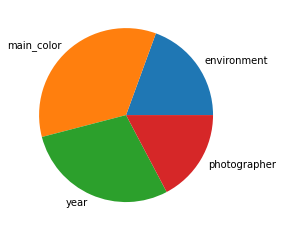

In [ ]:
plt.pie(dtc.feature_importances_,labels=['environment','main_color','year','photographer'])

In [ ]:
def maketestDf(limit):
  data = []
  photographer = ["Romain","Maxime","Michel","Denis","Jaquie","Fares"]

  for environment in os.listdir("/content/images/Data-Mining/archive/seg_train"):
      i=0
      print("[$] Loaded %s" %(environment,))

      for image in os.listdir("/content/images/Data-Mining/archive/seg_train" +"/"+ str(environment)):
        i+=1

        info = [
                environment+'/'+image, 
                environment, 
                getYear(),
                getPhotographer(),
                getMainColor("/content/images/Data-Mining/archive/seg_train/"+environment+"/"+image)
                ]

        try: # There may be some unseen colors. We ignore the data in that case
          with warnings.catch_warnings(): # Ignoring the warnings
            warnings.simplefilter("ignore")
            
            prediction = dtc.predict( # Making the prediction for each image in the training dataset
              [
                  [
                  le2.transform([info[1]])[0],
                  le3.transform([info[2]])[0], 
                  le4.transform([info[3]])[0],
                  le5.transform([info[4]])[0]
                  ]
              ])
            
            info.append(le6.inverse_transform(prediction)[0])

            data.append(info)

        except ValueError:
          print("[$] An unseen variable has been detected. It will be ignored.")
          pass
        
        if i==limit:
          break
        
  

  return pd.DataFrame(data,
                      columns = ['filename','environment','year','photographer','main_color','prediction'])


Limit to gain some time: if you want more data, then put a higher number.

In [ ]:
limit = 100

df = maketestDf(limit)

[$] Loaded buildings
[$] Loaded street
[$] An unseen variable has been detected. It will be ignored.
[$] Loaded sea
[$] Loaded forest
[$] An unseen variable has been detected. It will be ignored.
[$] Loaded glacier
[$] Loaded mountain


### Impact of the environment

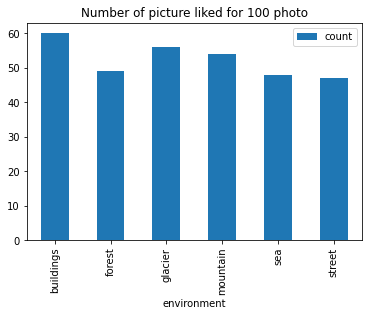

In [ ]:
grouped = df.groupby(['environment','prediction']).count() # Counting the number of Like/Dislike per environment
grouped = grouped.rename(columns={'year':'count'})['count'].reset_index()
grouped = grouped[grouped['prediction']=='Like']

title = "Number of picture liked for %s photo" % (limit,)

grouped.plot(x='environment', y='count', kind='bar',title=title)

## Impact of the year

**NOTE:** We did not succeed in putting a legend. You can however read the number on the graph and associate it to the year in the printed dataframe

    year  count
0   1995      2
7   2001     11
12  2005     45
13  2006     57
15  2007     69
17  2008      1
19  2009     48
21  2010     37
22  2011     32
24  2012      3
26  2013      4
28  2014      1
30  2015      1
31  2016      1
33  2017      2


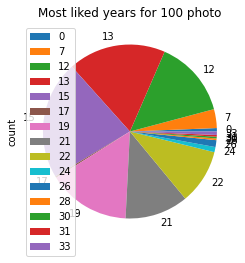

In [ ]:
grouped = df.groupby(['year','prediction']).count()
grouped = grouped.rename(columns={'environment':'count'})['count'].reset_index()
grouped = grouped[grouped['prediction']=='Like']
del grouped['prediction']
print(grouped)

title = "Most liked years for %s photo" % (limit,)
grouped.plot(y='count', x='year', kind='pie', title=title, legend=True)

# Importance of the photographer

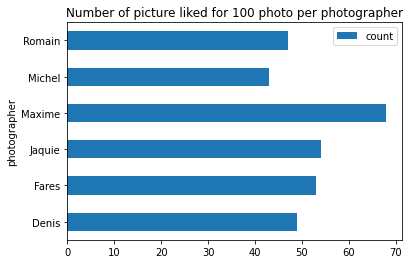

In [ ]:
grouped = df.groupby(['photographer','prediction']).count() # Counting the number of Like/Dislike per environment
grouped = grouped.rename(columns={'year':'count'})['count'].reset_index()
grouped = grouped[grouped['prediction']=='Like']

title = "Number of picture liked for %s photo per photographer" % (limit,)

grouped.plot(x='photographer', y='count', kind='barh',title=title)

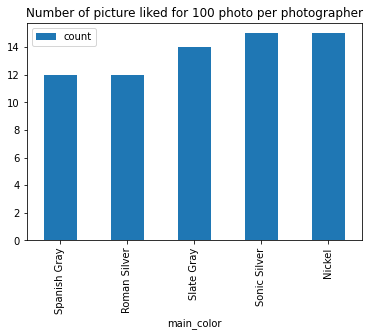

In [ ]:
grouped = df.groupby(['main_color','prediction']).count() # Counting the number of Like/Dislike per environment
grouped = grouped.rename(columns={'year':'count'})['count'].reset_index()
grouped = grouped[grouped['prediction']=='Like']

grouped = grouped.sort_values('count').tail()

title = "Number of picture liked for %s photo per photographer" % (limit,)

grouped.plot(x='main_color', y='count', kind='bar',title=title)

# Recommendation System

## Showing photos the client would like



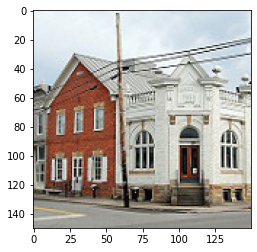

In [142]:
df_liked = df[df['prediction']=='Like']

first = df_liked.iloc[1]['filename']
image = mpimg.imread("/content/images/Data-Mining/archive/seg_train/"+first)
imgplot = plt.imshow(image)

## Report